In [1]:
# sudo -HE mlp-run mountainsort3.mlp sort --raw=data/raw.mda --geom=data/geom.csv --firings_out=data/firings2.mda --_params=params.json --curate=true

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
%matplotlib inline
#from tqdm import tqdm_notebook as tqdm
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import sys
sys.path.insert(0, '/mnt/cube/tsainbur/Projects/github_repos/mountainsort/packages/pyms/')
from mlpy import *


In [3]:
import sys
sys.path.insert(0, '../../../mountainsort/packages/pyms/')

In [4]:
from mlpy import *

In [6]:
root = '/mnt/cube/tsainbur/Projects/github_repos/mountainsort_examples/examples/example_tim_bird2/'
sorted_spikes=DiskReadMda(root + 'data/firings_1_hr.mda')
raw=DiskReadMda(root + 'data/B1169_test_60mins.mda')
#sorted_spikes=readmda('data/firings_uncurated.mda')

In [7]:
print(sorted_spikes.dims())

[3, 247444]


In [8]:
print(raw.dims())

[32, 72000000]


In [9]:
rate = fs= 20000

In [10]:
#np.shape(raw)

In [11]:
#seconds = np.shape(raw)[1]/rate
#print('Dataset length: ',seconds, ' seconds')

In [9]:
sample_neural_data = raw.readChunk(i1=0,i2=0,N1=32,N2=30000).T
print(np.shape(sample_neural_data))

(30000, 32)


In [10]:
def norm(X):
    return (X - np.min(X)) / (np.max(X)- np.min(X))

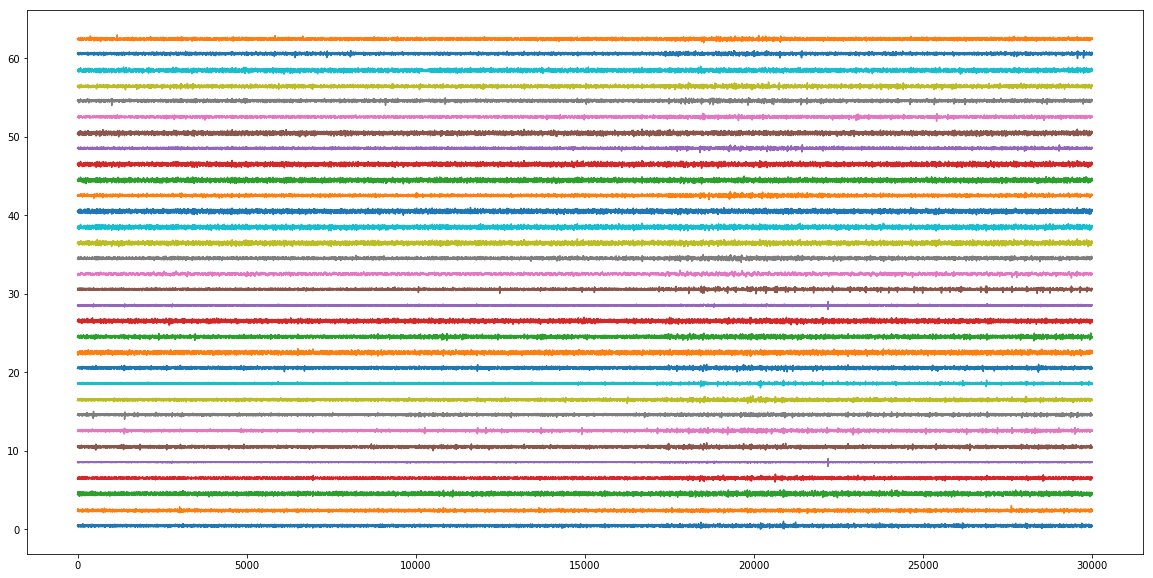

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20, 10))
for i in range(np.shape(sample_neural_data)[1]):
    plt.plot(norm(sample_neural_data[:,i])+i*2)

In [15]:
from scipy.io import wavfile

In [16]:
len(wavfile.read('/mnt/cube/tsainbur_raw/B1169/Tim2_stims (1)/resampled/data/g_6/-0d15625_-0d15625.wav')[1])

40171

In [17]:
sorted_spikes.dims()

[3, 247444]

In [18]:
spike_sample = sorted_spikes.readChunk(i1=0,i2=0,N1=3,N2=100).T
print(np.shape(spike_sample))

(100, 3)


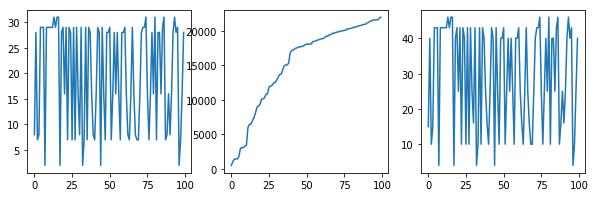

In [19]:
fig, ax = plt.subplots(ncols=3, nrows = 1, figsize=(10,3))
ax[0].plot(spike_sample[:,0])
ax[1].plot(spike_sample[:,1])
ax[2].plot(spike_sample[:,2])

In [20]:
rate = 20000 
time_len = .005

In [21]:
cluster = 2

In [22]:
# sorted_spikes 0: channel, 1: sample number, 2: cluster number

In [23]:
np.shape(raw.readChunk(i1=0,i2=0,N1=32,N2=30000))

(32, 30000)

In [24]:
all_spikes = sorted_spikes.readChunk(i1=0,i2=0,N1=sorted_spikes.dims()[0],N2=sorted_spikes.dims()[1])
np.shape(all_spikes)

(3, 247444)

In [25]:
np.max(all_spikes[1,])/rate/60

59.998903333333338

In [26]:
len(np.unique(all_spikes[2]))

15

2.0 1 [ 89557.  90281.  92822.]


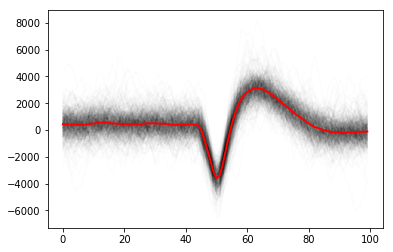

In [27]:
for cluster in np.unique(all_spikes[2]):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6, 4))
    cluster_spikes = np.where(all_spikes[2] == cluster)[0]
    cluster_channel = int(all_spikes[0][cluster_spikes][0])
    print(cluster, cluster_channel,all_spikes[1][cluster_spikes][:3])
    asw = []
    for i, cs in enumerate(cluster_spikes):
        spike_time_sample = int(all_spikes[1][cs])
        window = [spike_time_sample - int(rate*time_len/2), spike_time_sample + int(rate*time_len/2)]
        #print(breakme)
        spike_window = raw.readChunk(i1=0,i2=window[0],N1=32,N2=window[1] - window[0])[cluster_channel-1]
        #print(spike_window)
        if len(spike_window) != 100:break
        asw.append(spike_window)
        plt.plot(spike_window, color = 'k', alpha = .01)
        
        if i ==500:break
    plt.plot(np.mean((asw), axis = 0), color='red',lw=2)
    plt.show()
    break


In [28]:
time_to_sample = 1
samps_to_samp = int(time_to_sample*rate)

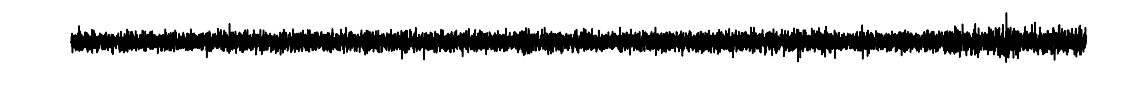

In [29]:
for cluster in np.unique(all_spikes[2]):
    cluster_spikes = np.where(all_spikes[2] == cluster)[0]
    cluster_channel = int(all_spikes[0][cluster_spikes][0])
    channel_sample = raw.readChunk(i1=0,i2=0,N1=32,N2=samps_to_samp)[cluster_channel-1,:]
    
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20, 1))
    plt.plot(norm(channel_sample), color='k')

    for i, cs in enumerate(cluster_spikes):
        if all_spikes[1][cs] > samps_to_samp:
            continue
        ax.axvline(all_spikes[1][cs], ls='solid', color='red', ymin=.75, ymax=1)
    plt.axis('off')
    plt.show()
    break


In [108]:
def get_textmark(char_array):
    return ''.join([chr(xi) for xi in char_array]).replace('\x00', '')

def load_stim_info(s2mat):
    try:
        with h5py.File(s2mat, 'r') as f:
            times = np.array(f['stimulus_textmark']['times']).T.squeeze()
            codes = np.array([c for c in f['stimulus_textmark']['codes'][0,:]])
            names = np.array([get_textmark(x) for x in np.transpose(f['stimulus_textmark']['text'])])
    except KeyError:
        with h5py.File(s2mat, 'r') as f:
            times = np.array(f['stimulus_']['times']).T.squeeze()
            codes = np.array([c for c in f['stimulus_']['codes'][0,:]])
            names = np.array([get_textmark(x) for x in np.transpose(f['stimulus_']['text'])])

    assert len(codes)==len(times)
    assert len(codes)==len(names)
    return codes, times, names
def load_digmark(s2mat):
    with h5py.File(s2mat, 'r') as f:
        times = np.array(f['DigMark']['times']).T.squeeze()
        codes = np.array([str(chr(c)) for c in f['DigMark']['codes'][0,:]])
    assert len(codes)==len(times)
    return codes, times
def _is_not_floatable(arg):
    ''' returns True if arg cannot be converted to float
    '''
    try:
        float(arg)
        return False
    except ValueError:
        return True
def get_stim_start(stim_end_row,digmarks):
    '''
    Finds the digmark row corresponding to the beginning of a stimulus
    Parameters
    ------
    stim_end_row : pandas dataframe
        The row of the digmark dataframe corresponding to the end of a stimulus
    digmarks : pandas dataframe
        The digmark dataframe
    Returns
    ------
    this_trial : pandas dataframe
        Row containing the digmark corresponding to the start of the stimulus
    '''
    rec,ts = stim_end_row['recording'],stim_end_row['time_samples']
    mask = (
        (digmarks['recording']==rec)
        & (digmarks['time_samples'] < ts)
        & ~digmarks['codes'].str.contains('[RCL]')
        )
    this_trial_mask = (
        digmarks[mask].iloc[::-1]['codes'].apply(FindEnd().check).iloc[::-1]
        & digmarks[mask]['codes'].str.contains('<')
    )
    this_trial = digmarks[mask][this_trial_mask]
    return this_trial.iloc[0]
class FindEnd():
    def __init__(self):
        self.keep = True
    def check(self,code):
        if code in '()FfTt]N>#':
            self.keep = False
        return self.keep
def get_stim_info(trial_row,stimulus,fs):
    '''
    finds the stimulus info for a trial.
    Parameters
    -------
    trial_row
        row from a trial
    stimulus
        pandas dataframe of all stimulus events
    fs : float
        sampling rate of block
    Returns
    -------
    digmark row for the response event
    '''
    rec,samps = trial_row['recording'], trial_row['time_samples']
    stim_mask = (
        (stimulus['recording']==rec)
        & (stimulus['time_samples']>(samps-1.0*fs))
        & (stimulus['time_samples']<(samps+fs))
        )

    if stim_mask.sum()>0:
        return stimulus[stim_mask].iloc[0]
    else:
        return dict(codes=np.nan,time_samples=np.nan,recording=np.nan,text=np.nan)


In [178]:
import sys
sys.path.insert(0, '/mnt/cube/tsainbur/Experiments/ephys_analysis/ephys-analysis/')
from ephys.events import *

In [31]:
mat_file = '/mnt/cube/tsainbur/Experiments/ephys_analysis/B1169/matfiles/Pen01_Lft_AP2500_ML500__Site01_Z1450__B1169_cat_P01_S01_1/SubB1169Pen00Site01Epc07File01_11-22-17+09-49-24_B1169_block.mat'

In [160]:
codes, times, names = load_stim_info(mat_file)
times = (times * rate).round().astype(np.uint64)
stimulus = pd.DataFrame(np.array([codes, names, times]).T, columns = ['codes', 'text', 'time_samples'])
stimulus = stimulus[1:]
stimulus['time_samples'] = stimulus['time_samples'].astype('int')
stimulus[:5]

,codes,text,time_samples
1,244,6.266499,125330
2,0,-3d984375_2d421875,125330
3,244,8.537199,170744
4,73,-3d671875_-5d859375,170744
5,244,10.826099,216522


In [161]:
# mask non-trial stims
stim_mask = (
        ~(stimulus['text'].astype(str).str.contains('date'))
        & (stimulus['text'].apply(_is_not_floatable)) # occlude floats
        )
stimulus= stimulus[stim_mask]
stimulus['recording'] = 0

In [162]:
stimulus[:3]

,codes,text,time_samples,recording
2,0,-3d984375_2d421875,125330,0
4,73,-3d671875_-5d859375,170744,0
6,73,-2d734375_-14d296875,216522,0


In [163]:
codes, times = load_digmark(mat_file)
times = (times * rate).round().astype(np.uint64)

In [164]:
len(codes), len(times)

(10684, 10684)

In [165]:
digmarks = pd.DataFrame(np.array([codes, times]).T, columns = ['codes', 'time_samples'])
digmarks['recording'] = 0
digmarks['time_samples'] = digmarks['time_samples'].astype('int')

In [166]:
digmarks[:5]

,codes,time_samples,recording
0,<,124985,0
1,>,145070,0
2,(,145072,0
3,),162054,0
4,<,170043,0


In [167]:
np.unique(digmarks['codes'])

array(['(', ')', '<', '>'], dtype=object)

In [168]:
stim_end_mask = digmarks['codes'].isin(('>','#')).values
stim_end_mask[:3]

array([False,  True, False], dtype=bool)

In [169]:
tqdm().pandas()
trials = digmarks[stim_end_mask].progress_apply(lambda row: get_stim_start(row,digmarks),axis=1)[:]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2671), HTML(value='')))

In [170]:
trials[:3]

,codes,time_samples,recording
1,<,124985,0
5,<,170043,0
9,<,216055,0


In [171]:
trials.reset_index(inplace=True)
del trials['index']
del trials['codes']
trials[:3]

,time_samples,recording
0,124985,0
1,170043,0
2,216055,0


In [172]:
row = trials.loc[0]
row

time_samples    124985
recording            0
Name: 0, dtype: int64

In [174]:
trials['stimulus'] = trials.progress_apply(lambda row: get_stim_info(row,stimulus,fs)['text'],axis=1)

In [182]:
trials['stimulus_end'] = trials.progress_apply(lambda row: get_stim_end(row,digmarks,fs)['time_samples'],axis=1)

HBox(children=(IntProgress(value=0, max=2671), HTML(value='')))

319/|/ 12%|| 319/2671 [00:20<00:30, 77.59it/s]

In [183]:
trials['response'] = trials.progress_apply(lambda row: get_response(row,digmarks,fs)['codes'],axis=1)
trials['response_time'] = trials.progress_apply(lambda row: get_response(row,digmarks,fs)['time_samples'],axis=1)
trials['consequence'] = trials.progress_apply(lambda row: get_consequence(row,digmarks,fs)['codes'],axis=1)
trials['correct'] = trials['consequence'].progress_apply(is_correct)

HBox(children=(IntProgress(value=0, max=2671), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2671), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2671), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2671), HTML(value='')))

In [186]:
trials[:3]

,time_samples,recording,stimulus,stimulus_end,response,response_time,consequence,correct
0,124985,0,-3d984375_2d421875,145070,NaN,NaN,NaN,NaN
1,170043,0,-3d671875_-5d859375,190129,NaN,NaN,NaN,NaN
2,216055,0,-2d734375_-14d296875,236141,NaN,NaN,NaN,NaN


In [212]:
len(trials), len(np.unique(trials['stimulus']))

(2671, 2671)

In [213]:
trials['stim_points'] = [[float(j.replace('d', '.')) for j in i.split('_')] for i in trials['stimulus'].values]

In [214]:
trials['x_loc'] = np.array(list(trials['stim_points']))[:,0]
trials['y_loc'] = np.array(list(trials['stim_points']))[:,1]

In [198]:
spikes = pd.DataFrame(all_spikes.T, columns = ['channel', 'time_samples', 'cluster'])
spikes['recording'] = 0
spikes['cluster'] = spikes['cluster'].astype('int32')
spikes['channel'] = spikes['cluster'].astype('int32')
spikes['time_samples'] = spikes['time_samples'].astype('int32')

In [199]:
spikes[:3]

,channel,time_samples,cluster,recording
0,15,465,15,0
1,40,1011,40,0
2,10,1381,10,0


In [200]:
mat_data = h5py.File(mat_file, 'r')
aud_stims = mat_data['Aud__Stim_']['values']

In [201]:
ss = trials.loc[0]['time_samples']
se = trials.loc[0]['stimulus_end']

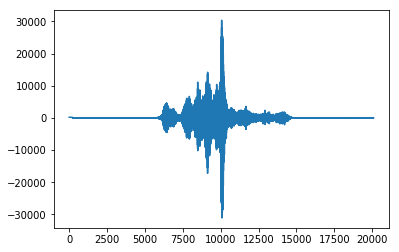

In [202]:
plt.plot((np.squeeze(aud_stims[:,ss:se])))

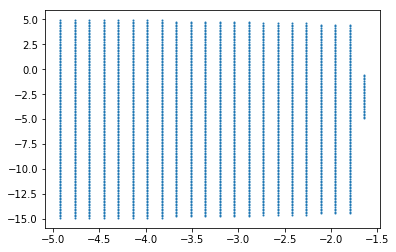

In [203]:
plt.scatter(trials['x_loc'], trials['y_loc'], s=1)

In [204]:
np.max(spikes['time_samples'])

71998684

In [215]:
import sys
sys.path.append('/mnt/cube/tsainbur/Experiments/ephys_analysis/ephys-analysis/')
from ephys import rasters, core, events

In [228]:
clusterID = 25
raster_window = [-.5, .5]

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

-1d640625_-0d546875
-1d640625_-0d703125
-1d640625_-0d859375
-1d640625_-1d015625
-1d640625_-1d171875
-1d640625_-1d328125
-1d640625_-1d484375
-1d640625_-1d640625
-1d640625_-1d796875
-1d640625_-1d953125
-1d640625_-2d109375
-1d640625_-2d265625
-1d640625_-2d421875
-1d640625_-2d578125
-1d640625_-2d734375
-1d640625_-2d890625



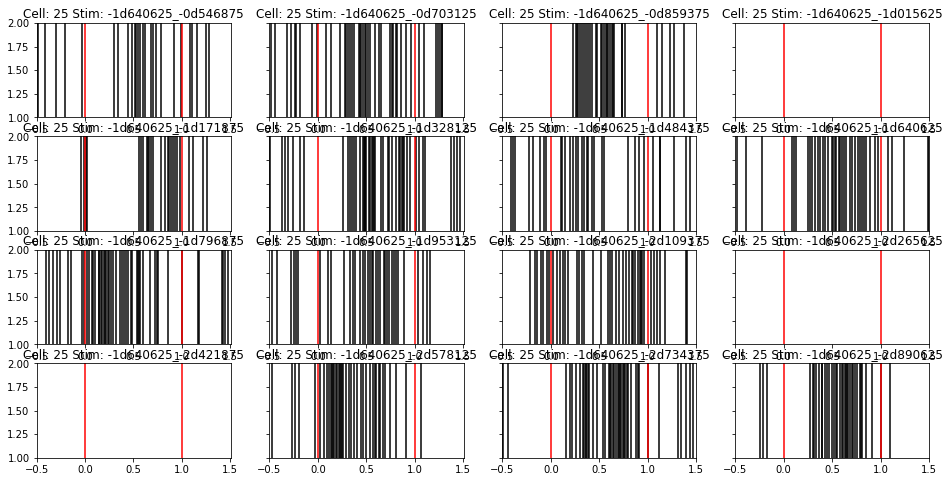

In [232]:
nrows= 4
ncols = 4
f, pltaxes = plt.subplots(nrows, ncols, sharey=True, figsize=(ncols*4,nrows*2))
rec = 0
for ind, stim in enumerate(tqdm(np.sort(np.unique(trials['stimulus']))[:nrows*ncols])):

    ax = pltaxes.flatten()[ind]
    rasters.plot_raster_cell_stim(spikes, trials, clusterID, stim, 
                                  raster_window, rec, rate, ax=ax)
    ax.set_title('Cell: {} Stim: {}'.format(clusterID, stim))
    print(stim)

In [220]:
stim = '-3d984375_2d421875'

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

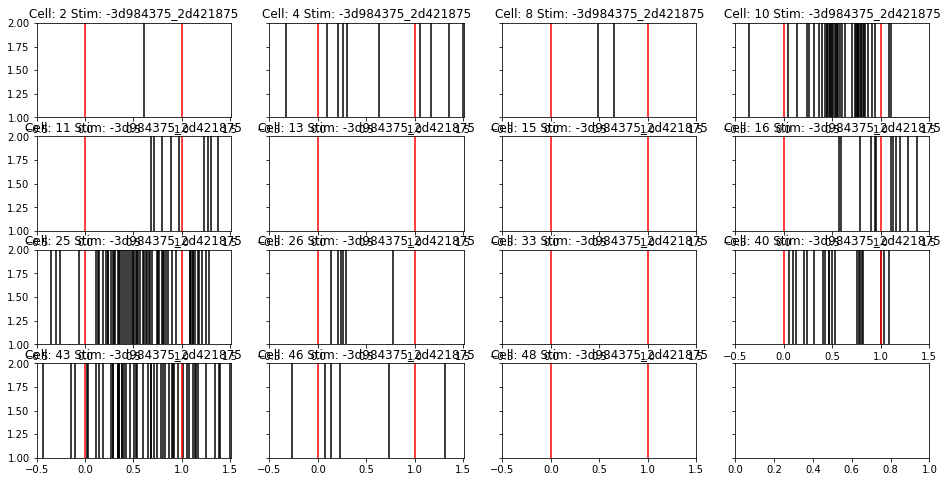

In [221]:
nrows= 4
ncols = 4
f, pltaxes = plt.subplots(nrows, ncols, sharey=True, figsize=(ncols*4,nrows*2))
rec = 0
for ind, clusterID in enumerate(tqdm(np.sort(np.unique(spikes['cluster']))[:nrows*ncols])):

    ax = pltaxes.flatten()[ind]
    rasters.plot_raster_cell_stim(spikes, trials, clusterID, stim, 
                                  raster_window, rec, rate, ax=ax)
    ax.set_title('Cell: {} Stim: {}'.format(clusterID, stim))


In [316]:
??rasters.plot_raster_cell_stim
#ax.plot([pltticks, pltticks], [1, ntrials+1], tick_color,
#                lw=tick_linewidth)

In [312]:
??rasters.do_raster

In [222]:
def create_gauss_psth(stimuli,fs, clusterID, period= [-1, 1], rec=0, hist_window_ms = 5, gaussian_sigma_ms = 2000):
    """ 
    """
    stim_trials = trials[trials['stimulus']==stim]
    ntrials = len(stim_trials)
    stim_starts = stim_trials['time_samples'].values
    stim_ends = stim_trials['stimulus_end'].values
    stim_end_seconds = np.unique((stim_ends - stim_starts)/fs)[0]
    window = [period[0], stim_end_seconds+period[1]]
    raster_data = []
    for trial, start in enumerate(stim_starts):
        sptrain = rasters.get_spiketrain(rec, start, clusterID, spikes, window, fs)
        raster_data.append(sptrain)
    histogrammed_spikes = np.histogram(np.concatenate(raster_data),bins = np.arange(window[0], window[1], hist_window_ms/1000.))[0]
    #print(gaussian_sigma_ms,hist_window_ms)
    gauss_psth = gaussian_filter(histogrammed_spikes.astype('float32'),gaussian_sigma_ms/hist_window_ms)
    return gauss_psth

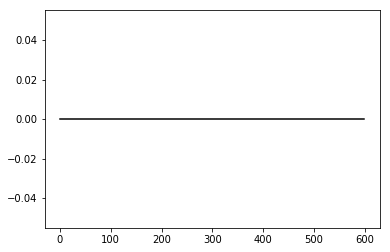

In [223]:
gauss_line = create_gauss_psth(stimuli = stim,fs=fs, clusterID=clusterID , period= [-1, 1], rec=0, hist_window_ms = 5, gaussian_sigma_ms = 20)
plt.plot(gauss_line, color='k')

In [314]:
raster_window

[-0.5, 0.5]

In [326]:
window

[-0.5, 1.5043]

In [333]:
for ind_new in range(ind, nrows*ncols):
    pltaxes.flatten()[ind_new].set_axis('off')

14
15


HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

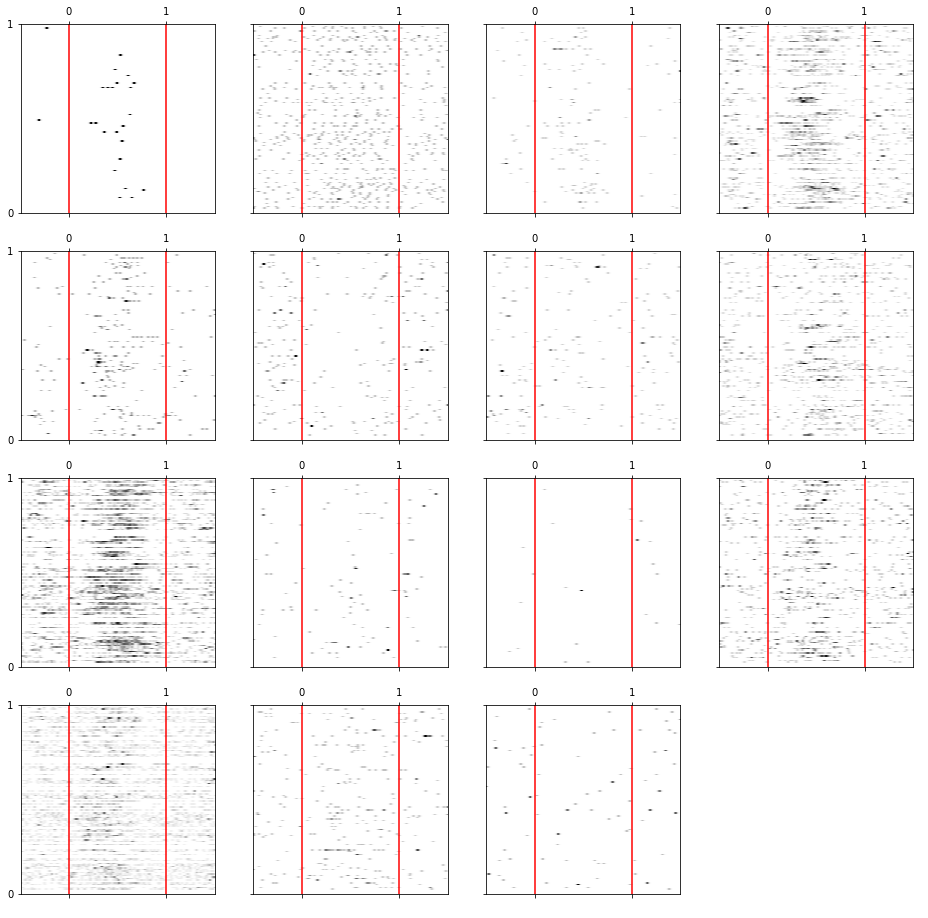

In [342]:
nrows= 4
ncols = 4
f, pltaxes = plt.subplots(nrows, ncols, sharey=True, figsize=(ncols*4,nrows*4))
rec = 0
for ind, clusterID in enumerate(tqdm(np.sort(np.unique(spikes['cluster']))[:nrows*ncols])):
    ax = pltaxes.flatten()[ind]
    subsample = trials[trials.x_loc == -3.984375].sort_values('y_loc')
    gauss_lines = []
    
    for stim in tqdm(list(subsample.stimulus),leave=False):
        gauss_lines.append(create_gauss_psth(stimuli = stim,fs=fs, clusterID=clusterID , period= [-1, 1],
                          rec=0, hist_window_ms = 5,
                          gaussian_sigma_ms = 20))
        
    #gauss_lines = np.array(gauss_lines)[np.sum(gauss_lines, axis=1) != 0]
    period = raster_window
    stim_trials = trials[trials['stimulus']==stim]
    ntrials = len(stim_trials)
    stim_starts = stim_trials['time_samples'].values
    stim_ends = stim_trials['stimulus_end'].values
    stim_end_seconds = np.unique((stim_ends - stim_starts)/fs)[0]
    window = [period[0], stim_end_seconds+period[1]]
    ax.matshow(gauss_lines, interpolation='nearest', aspect='auto' ,extent =[window[0], window[1], 0, 1],
               cmap=plt.get_cmap('Greys'))

    ax.axvline(0,color='red')
    ax.axvline(stim_end_seconds, color='red')
    
for ind_new in range(ind+1, nrows*ncols):
    pltaxes.flatten()[ind_new].axis('off')
plt.show()


In [344]:
spikes.to_pickle('for_tim_spikes.pickle')

In [343]:
trials.to_pickle('for_tim.pickle')